In [1]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
tweets_df = pd.read_csv('School_Shooting_Data.csv')

In [5]:
tweets_df.head()

Created At   
0  Tue Apr 30 23:57:07 +0000 2019  \
1  Tue Apr 30 23:29:19 +0000 2019   
2  Wed May 01 00:36:25 +0000 2019   
3  Wed May 01 06:48:12 +0000 2019   
4  Wed May 01 02:37:28 +0000 2019   

                                                Text   
0  This week: \n• Baltimore: 1 dead\n• Birmingham...  \
1  Two people dead and several injured at the Uni...   
2  Saddened to hear about the news at UNC Charlot...   
3  It’s a sad reality when there’s been 106 schoo...   
4  I'm heartsick for the victims of the #UNCC sho...   

                                              Source             User Name   
0  <a href="http://twitter.com/download/iphone" r...             Dante Vic  \
1  <a href="http://twitter.com" rel="nofollow">Tw...         Shannon Watts   
2  <a href="http://twitter.com/download/iphone" r...  President Parker  🇺🇸   
3  <a href="http://twitter.com/download/iphone" r...         Mike Kelleher   
4  <a href="http://twitter.com" rel="nofollow">Tw...      Elizabeth Warren   

             Location                                        Description   
0    Barcelona, Spain                           rhythm & blues 🎶 #UNCC17  \
1                 NaN  Founder of @MomsDemand, grassroots army of @Ev...   
2       Charlotte, NC  Excellence is the Only Standard|#NCCU19 Studen...   
3  Hazlet, New Jersey  •Part time owner of salernos pizzeria. •GQ Mag...   
4       Massachusetts  US Senator, MA. Former teacher & law professor...   

   Followers Count  Quote Count  Reply Count  Retweet Count  Favorite Count  
0              485          113        112.0         2441.0          4605.0  
1           310019          351        507.0         6612.0         16246.0  
2             7440            0          0.0           44.0            85.0  
3              546            0          0.0            0.0             0.0  
4          2452166           27        123.0          971.0          5327.0

In [6]:
# Data Preprocessing
def preprocess_text(text):
    # Remove special characters, links, mentions, and numbers
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Convert to lowercase and remove stopwords
    tokens = [token.lower() for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens

In [7]:
tweets_df['Text'].value_counts()

Text
Why can't Republicans just use thoughts and prayers to stop abortions like they do for school shootings?                                              519
*multiple school shooting happens*\n*planet is falling apart*\n*education system is complete shit*\n\nGovernment:\n\n*eve… https://t.co/XIgwFS9l2u    413
This is 18 year-old Kendrick Castillo. Castillo was shot &amp; killed at STEM School Highlands Ranch yesterday after lu… https://t.co/GKOTyjDpCH      215
There were 82 school shootings in 2018—mostly by white men, 0 by Arabs\n\nSchools: Let’s use an Arab Guy for our mass… https://t.co/LlSNIZlfvr        215
In the past three years, more kids have been killed in school shootings in our country than American military troop… https://t.co/lbhFBWDOuF          210
                                                                                                                                                     ... 
There have been 15 school shootings in the US so far this year https://

In [8]:
tweets_df['Text'].shape

(12617,)

In [9]:
# Drop duplicates based on the 'text' column
tweets_df.drop_duplicates(subset='Text', keep='first', inplace=True)

In [10]:
tweets_df['Text'].shape

(4961,)

In [11]:
tweets_df.shape

(4961, 11)

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

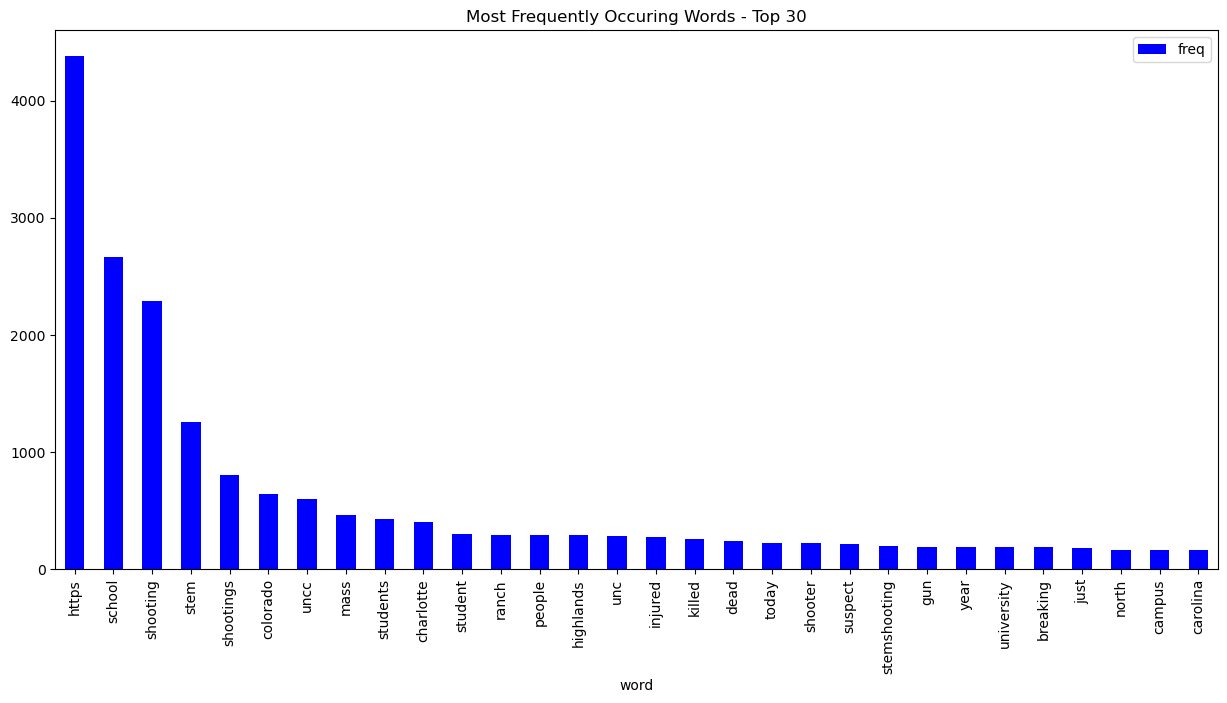

In [12]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(tweets_df['Text'])

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

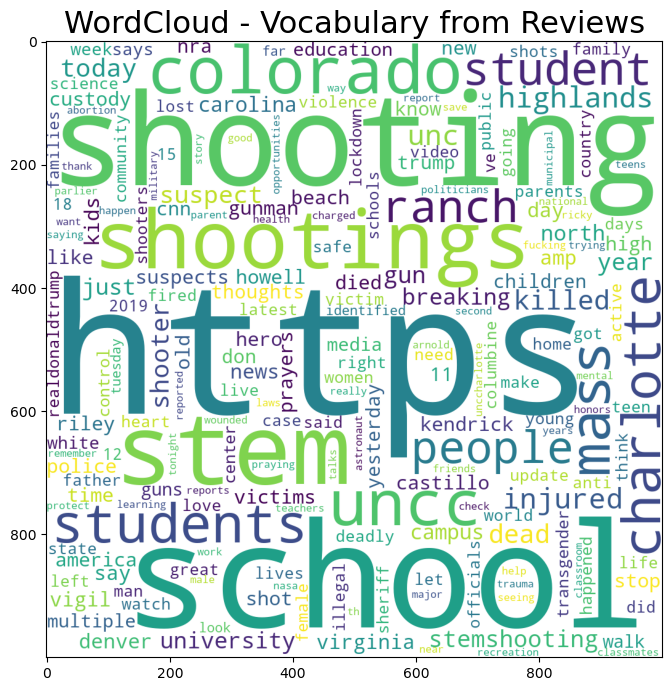

In [13]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

In [14]:
# Apply preprocessing to each tweet
tweets_df['cleaned_tokens'] = tweets_df['Text'].apply(preprocess_text)

In [15]:
tweets_df['cleaned_tokens'].head()

0    [week, baltimore, dead, birmingham, injured, n...
1    [two, people, dead, several, injured, universi...
2    [saddened, hear, news, unc, charlotte, thought...
3    [sad, reality, school, shootings, months, sinc...
4    [heartsick, victims, shooting, family, friends...
Name: cleaned_tokens, dtype: object

In [16]:
tweets_df.cleaned_tokens[1]

['two',
 'people',
 'dead',
 'several',
 'injured',
 'university',
 'north',
 'carolina',
 'charlotte',
 'single',
 'major']

### Using LDA model 

In [17]:
# Create a dictionary and corpus for LDA
id2word = corpora.Dictionary(tweets_df['cleaned_tokens'])
corpus = [id2word.doc2bow(tokens) for tokens in tweets_df['cleaned_tokens']]

In [18]:
# Build the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=42,
                                           passes=10,
                                           per_word_topics=True)

In [19]:
# Print the topics and their top words
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.050*"school" + 0.039*"stem" + 0.022*"shooting" + 0.014*"transgender" + 0.014*"public" + 0.013*"check" + 0.012*"illegal" + 0.011*"shootings" + 0.009*"father" + 0.008*"women"')
(1, '0.143*"mass" + 0.082*"shooting" + 0.055*"virginia" + 0.047*"beach" + 0.022*"dead" + 0.018*"killed" + 0.016*"least" + 0.014*"people" + 0.014*"us" + 0.014*"shootings"')
(2, '0.061*"charlotte" + 0.056*"unc" + 0.046*"uncc" + 0.033*"campus" + 0.030*"shooter" + 0.015*"shooting" + 0.015*"safe" + 0.015*"student" + 0.013*"please" + 0.013*"everyone"')
(3, '0.041*"stem" + 0.021*"via" + 0.015*"died" + 0.015*"education" + 0.015*"students" + 0.014*"shooting" + 0.012*"hero" + 0.010*"may" + 0.010*"go" + 0.010*"school"')
(4, '0.090*"another" + 0.076*"shooting" + 0.053*"school" + 0.013*"day" + 0.012*"mass" + 0.011*"time" + 0.010*"yet" + 0.010*"gun" + 0.009*"amp" + 0.009*"america"')
(5, '0.030*"kendrick" + 0.027*"castillo" + 0.022*"stem" + 0.014*"life" + 0.013*"students" + 0.013*"amp" + 0.013*"first" + 0.012*"man" + 0.00

In [20]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


In [21]:
# Visualize the topics using pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/opt/conda/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/opt/conda/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/opt/conda/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/opt/conda/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVers

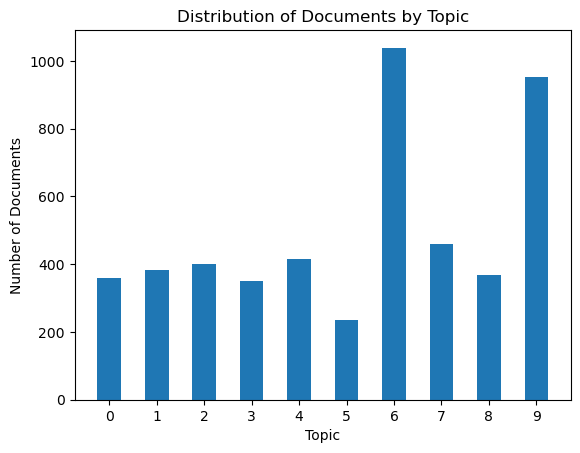

In [22]:
topic_distribution = [max(prob, key=lambda x: x[1])[0] for prob in lda_model.get_document_topics(corpus)]
plt.hist(topic_distribution, bins=range(lda_model.num_topics + 1), align='left', rwidth=0.5)
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.xticks(range(lda_model.num_topics))
plt.title('Distribution of Documents by Topic')
plt.show()

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


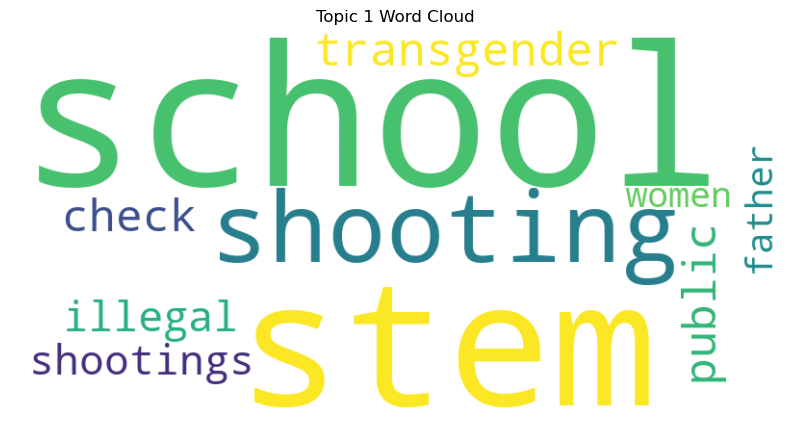

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


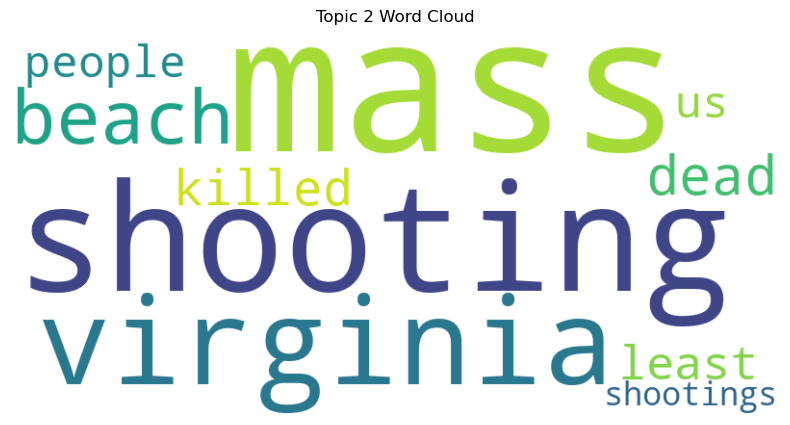

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


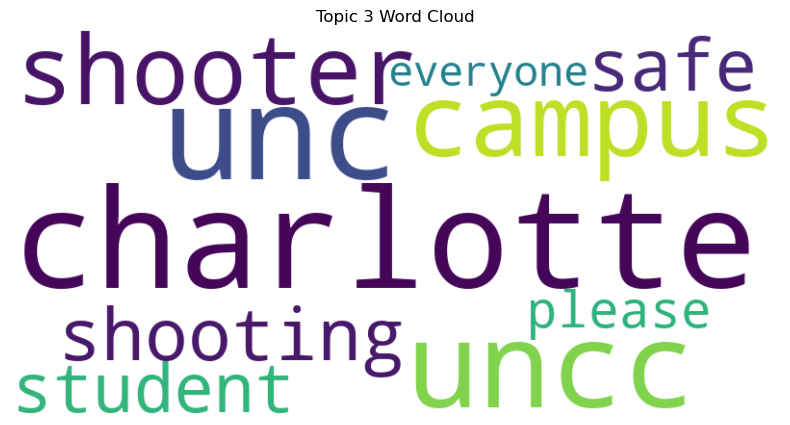

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


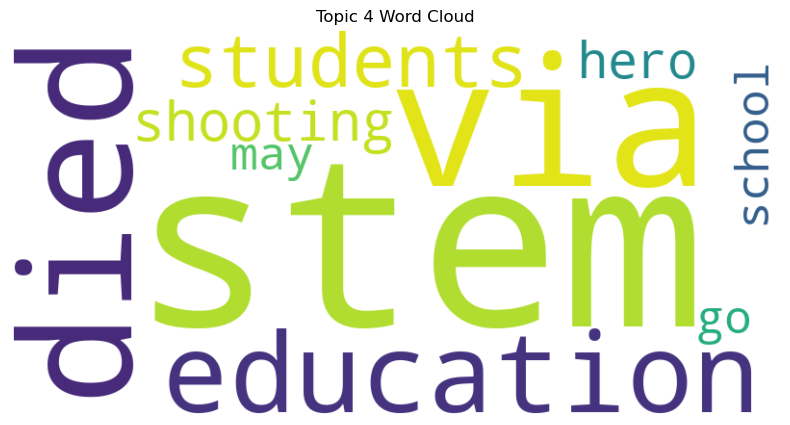

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


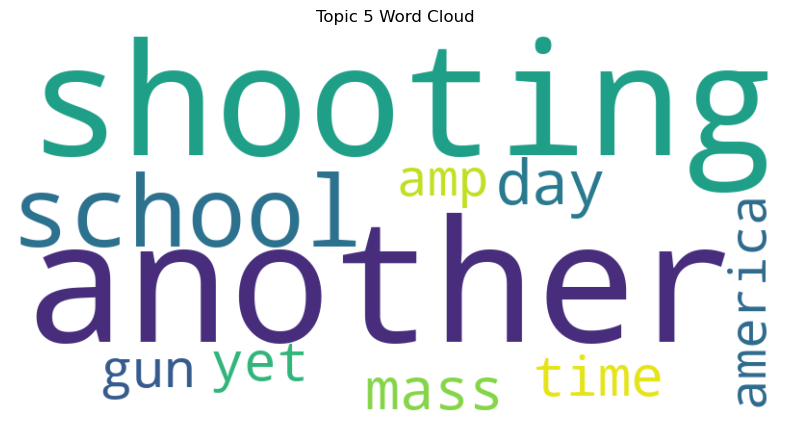

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


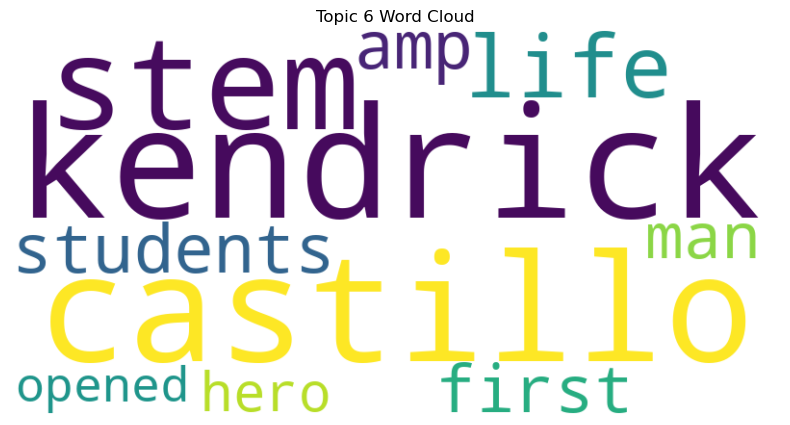

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


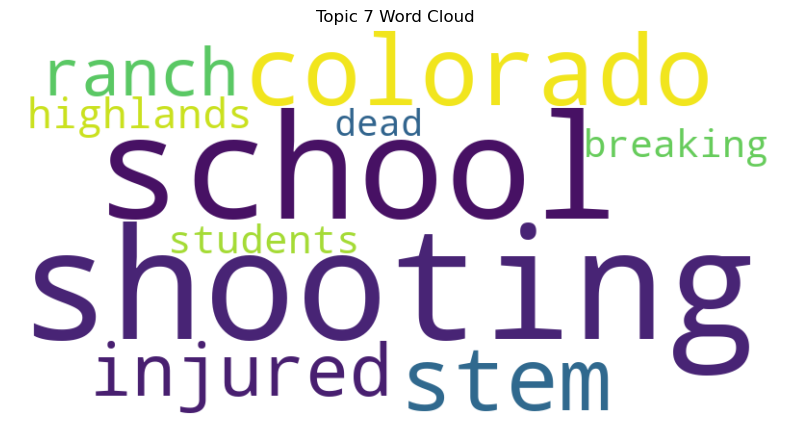

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


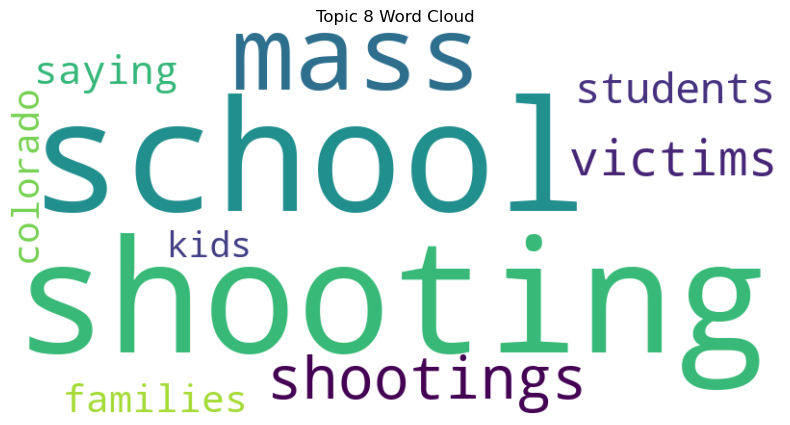

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


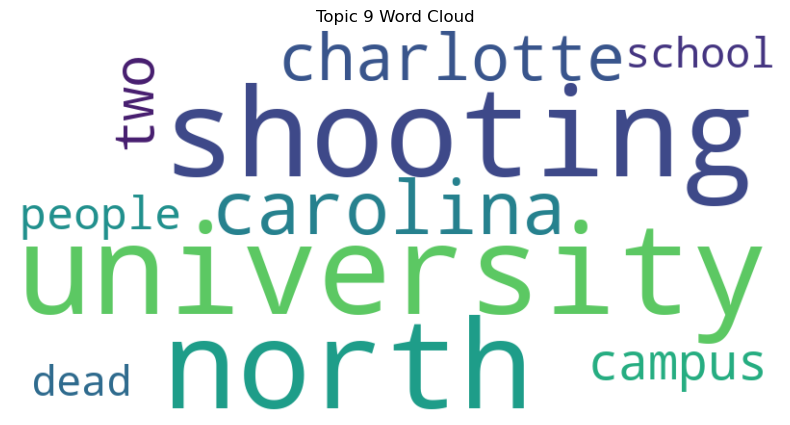

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


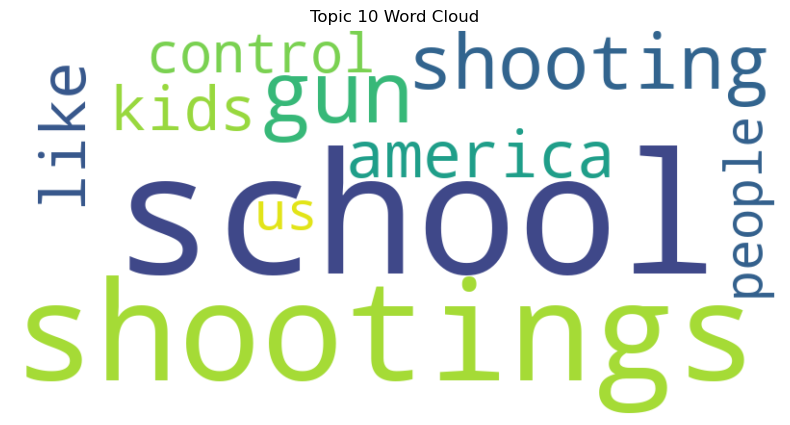

In [23]:
for topic_id, topic_words in lda_model.show_topics(formatted=False):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(topic_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topic {topic_id + 1} Word Cloud")
    plt.axis("off")
    plt.show()

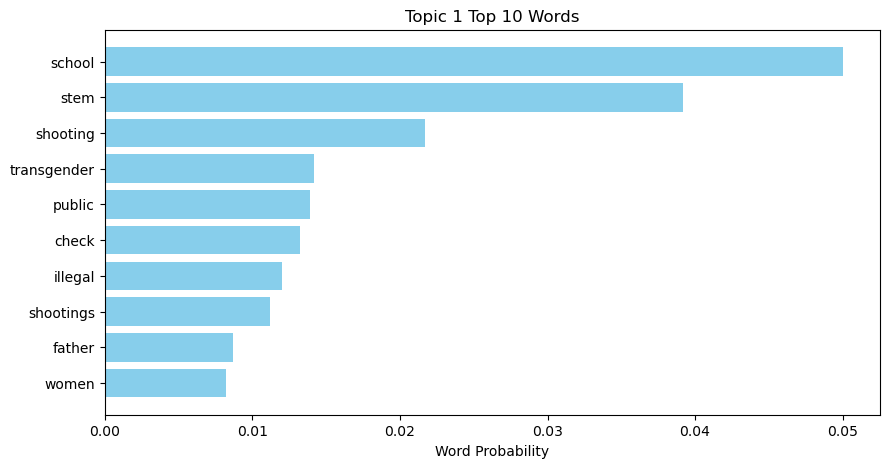

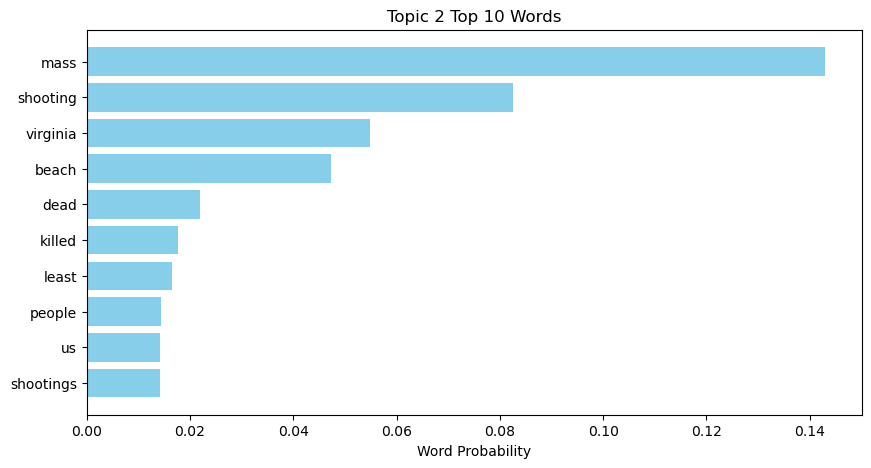

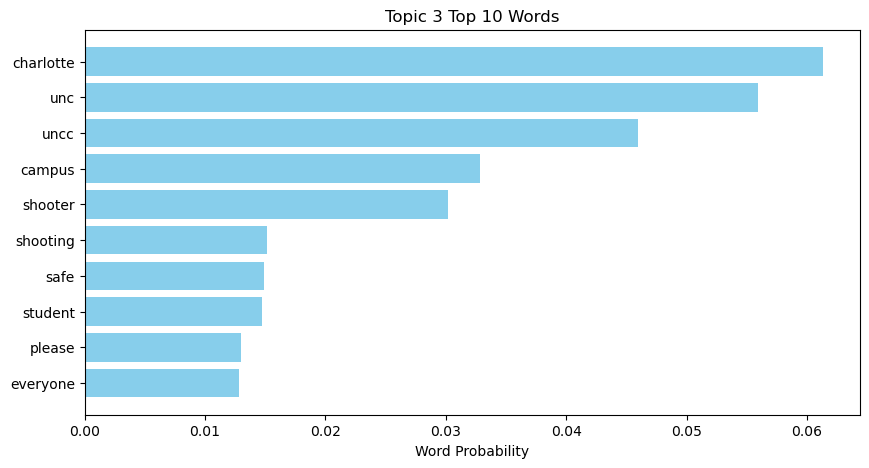

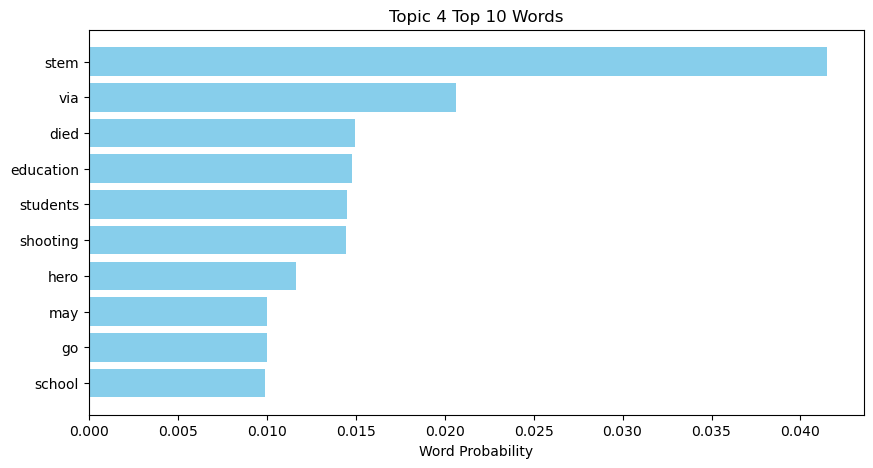

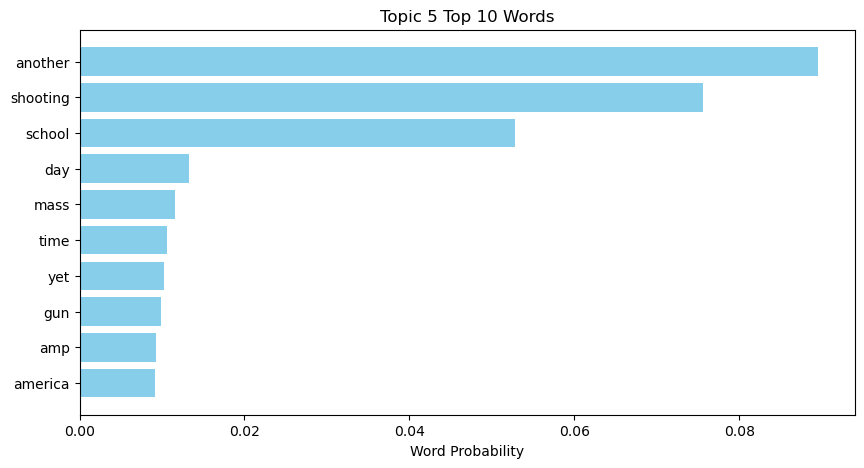

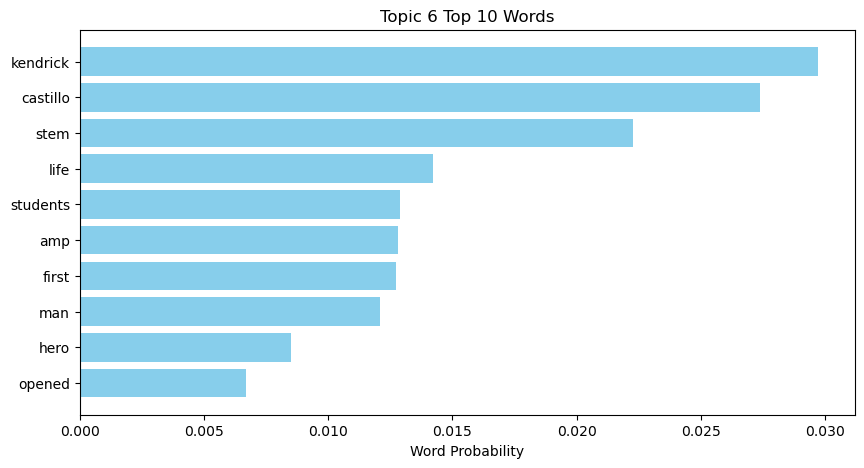

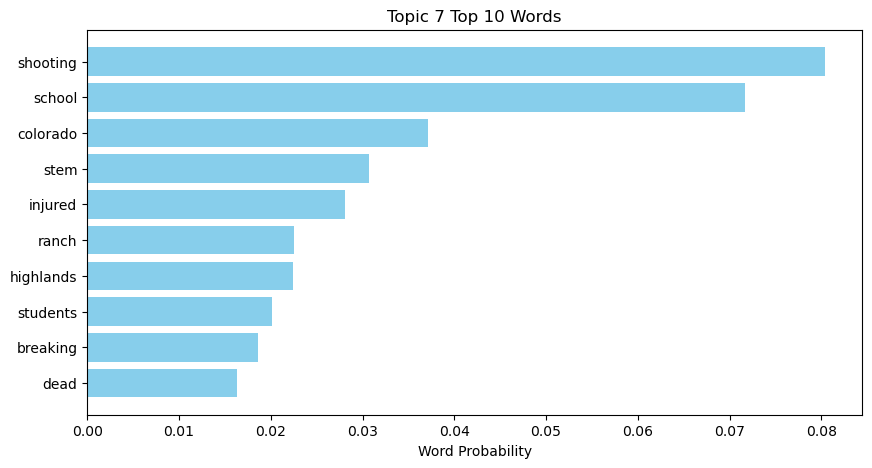

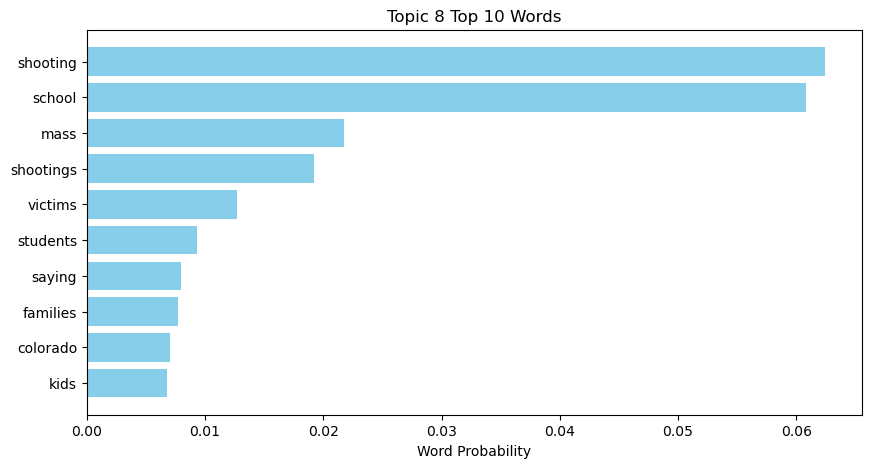

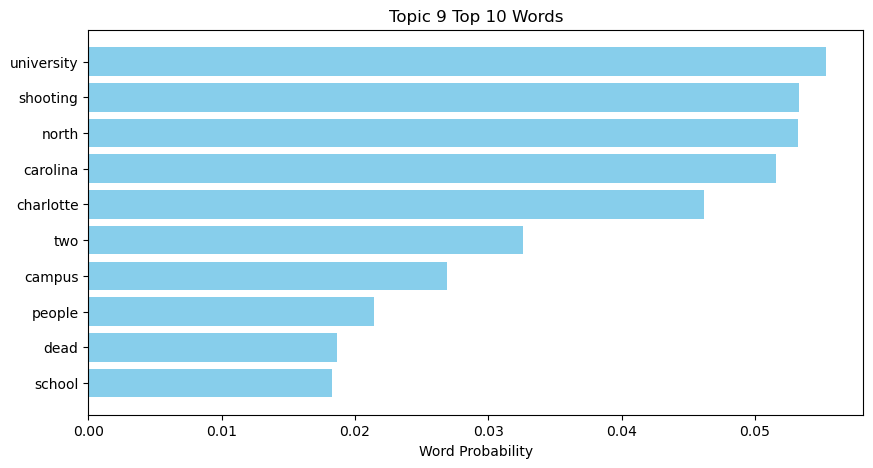

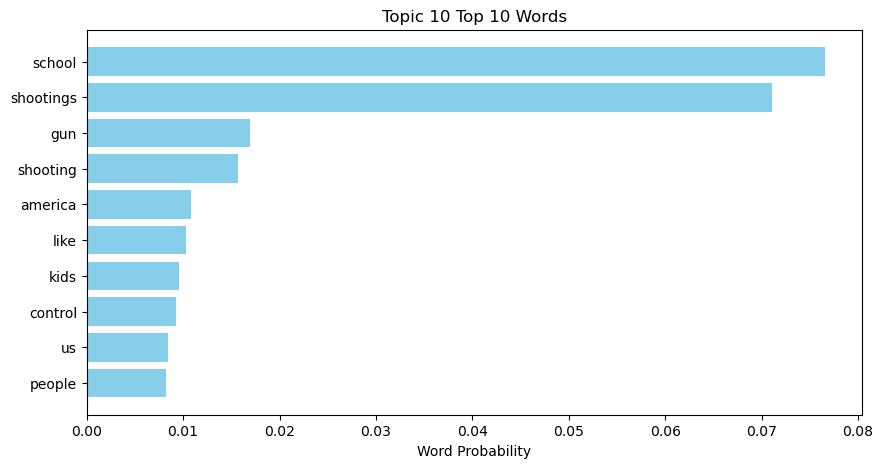

In [24]:
N = 10
topics = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=N, formatted=False)
for topic_id, topic_words in topics:
    words, word_probs = zip(*topic_words)
    plt.figure(figsize=(10, 5))
    plt.barh(words, word_probs, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f"Topic {topic_id + 1} Top {N} Words")
    plt.xlabel('Word Probability')
    plt.show()

#### Using another model Top2Vec

In [25]:
pip install top2vec

Note: you may need to restart the kernel to use updated packages.


#### Train Top2Vec Model:

In [26]:
from top2vec import Top2Vec
# Flatten the list of lists into a list of strings
documents = [' '.join(tokens) for tokens in tweets_df['cleaned_tokens']]
model = Top2Vec(documents=documents, speed="learn", workers=4)

2023-09-15 07:03:52.932625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 07:03:53.752039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-15 07:03:54,244 - top2vec - INFO - Pre-processing documents for training
2023-09-15 07:03:54,345 - top2vec - INFO - Creating joint document/word embedding
2023-09-15 07:04:02,362 - top2vec - INFO - Creating lower dimension embedding of documents
2023-09-15 07:06:44,677 - top2vec - INFO - Finding dense areas of documents
2023-09-15 07:06:44,960 - top2vec - INFO - Finding topics


In [27]:
num_topics = model.get_num_topics() 
print(num_topics)

17


In [28]:
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
topic_words 

array([['howell', 'riley', 'student', 'north', 'gunman', 'castillo',
        'kendrick', 'hero', 'victim', 'stop', 'everyone', 'died', 'unc',
        'high', 'shootings', 'carolina', 'go', 'lives', 'yesterday',
        'news', 'violence', 'life', 'heart', 'students', 'days', 'amp',
        'need', 'two', 'uncc', 'columbine', 'father', 'see', 'charlotte',
        'center', 'time', 'shooting', 'us', 'please', 'white', 'mass',
        'prayers', 'first', 'denver', 'campus', 'th', 'university',
        'know', 'says', 'victims', 'shot'],
       ['died', 'victim', 'howell', 'shooting', 'student', 'take', 'th',
        'columbine', 'heart', 'gunman', 'dead', 'stop', 'parents',
        'north', 'castillo', 'life', 'everyone', 'prayers', 'sheriff',
        'denver', 'hero', 'news', 'go', 'every', 'highlands', 'students',
        'know', 'new', 'lives', 'see', 'walk', 'campus', 'many', 'even',
        'like', 'transgender', 'live', 'one', 'case', 'carolina', 'need',
        'mass', 'amp', 'shoo

/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/opt/conda/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/opt/conda/lib/p

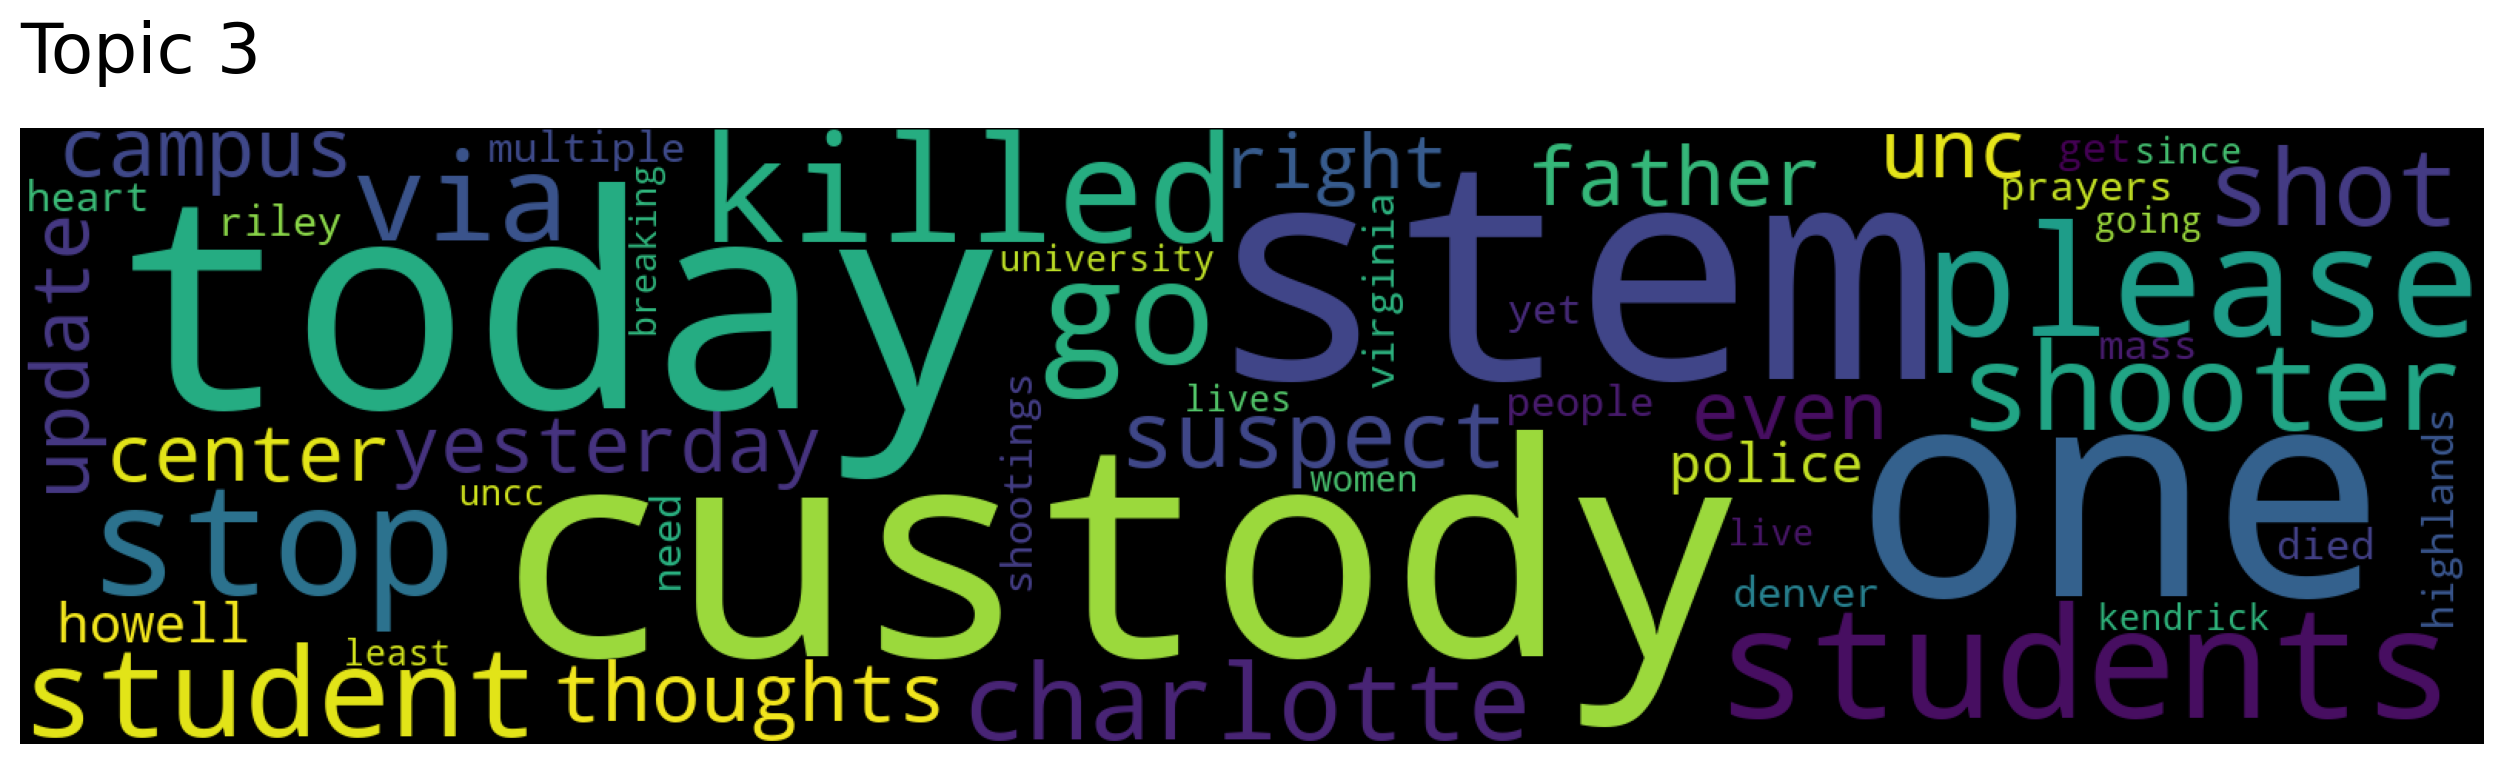

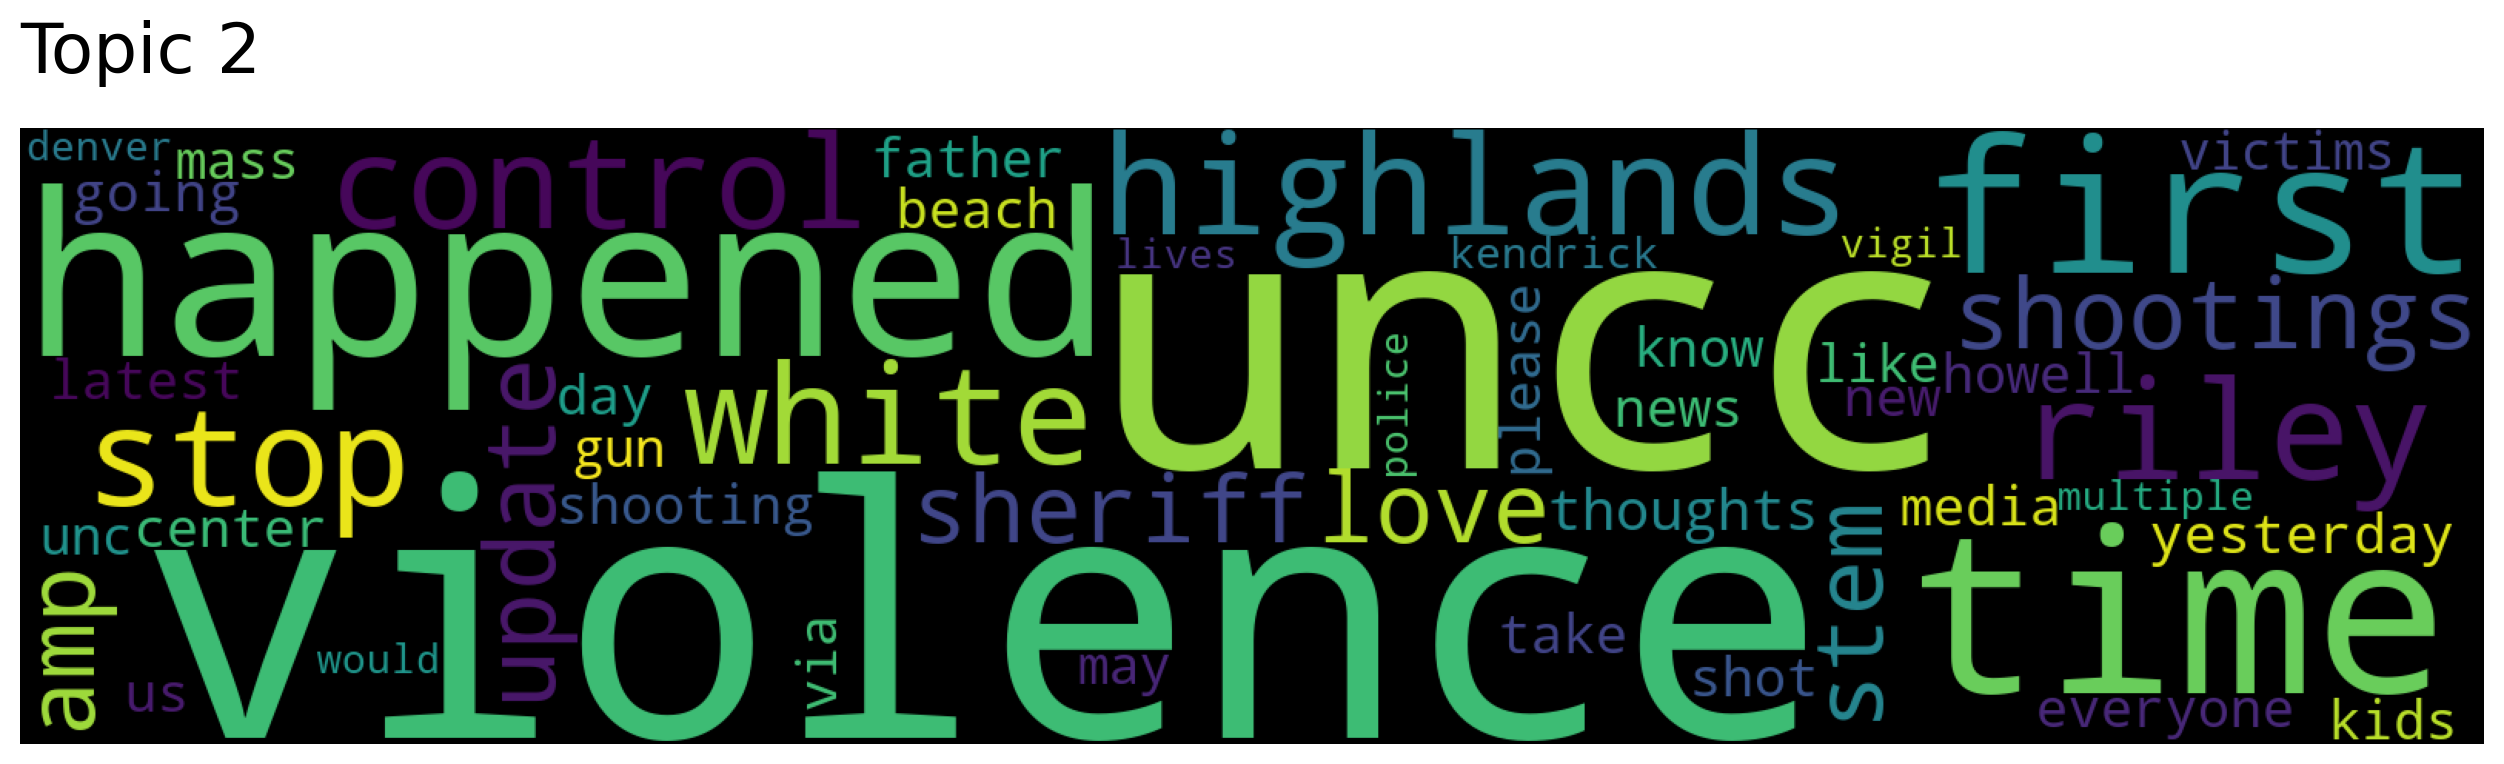

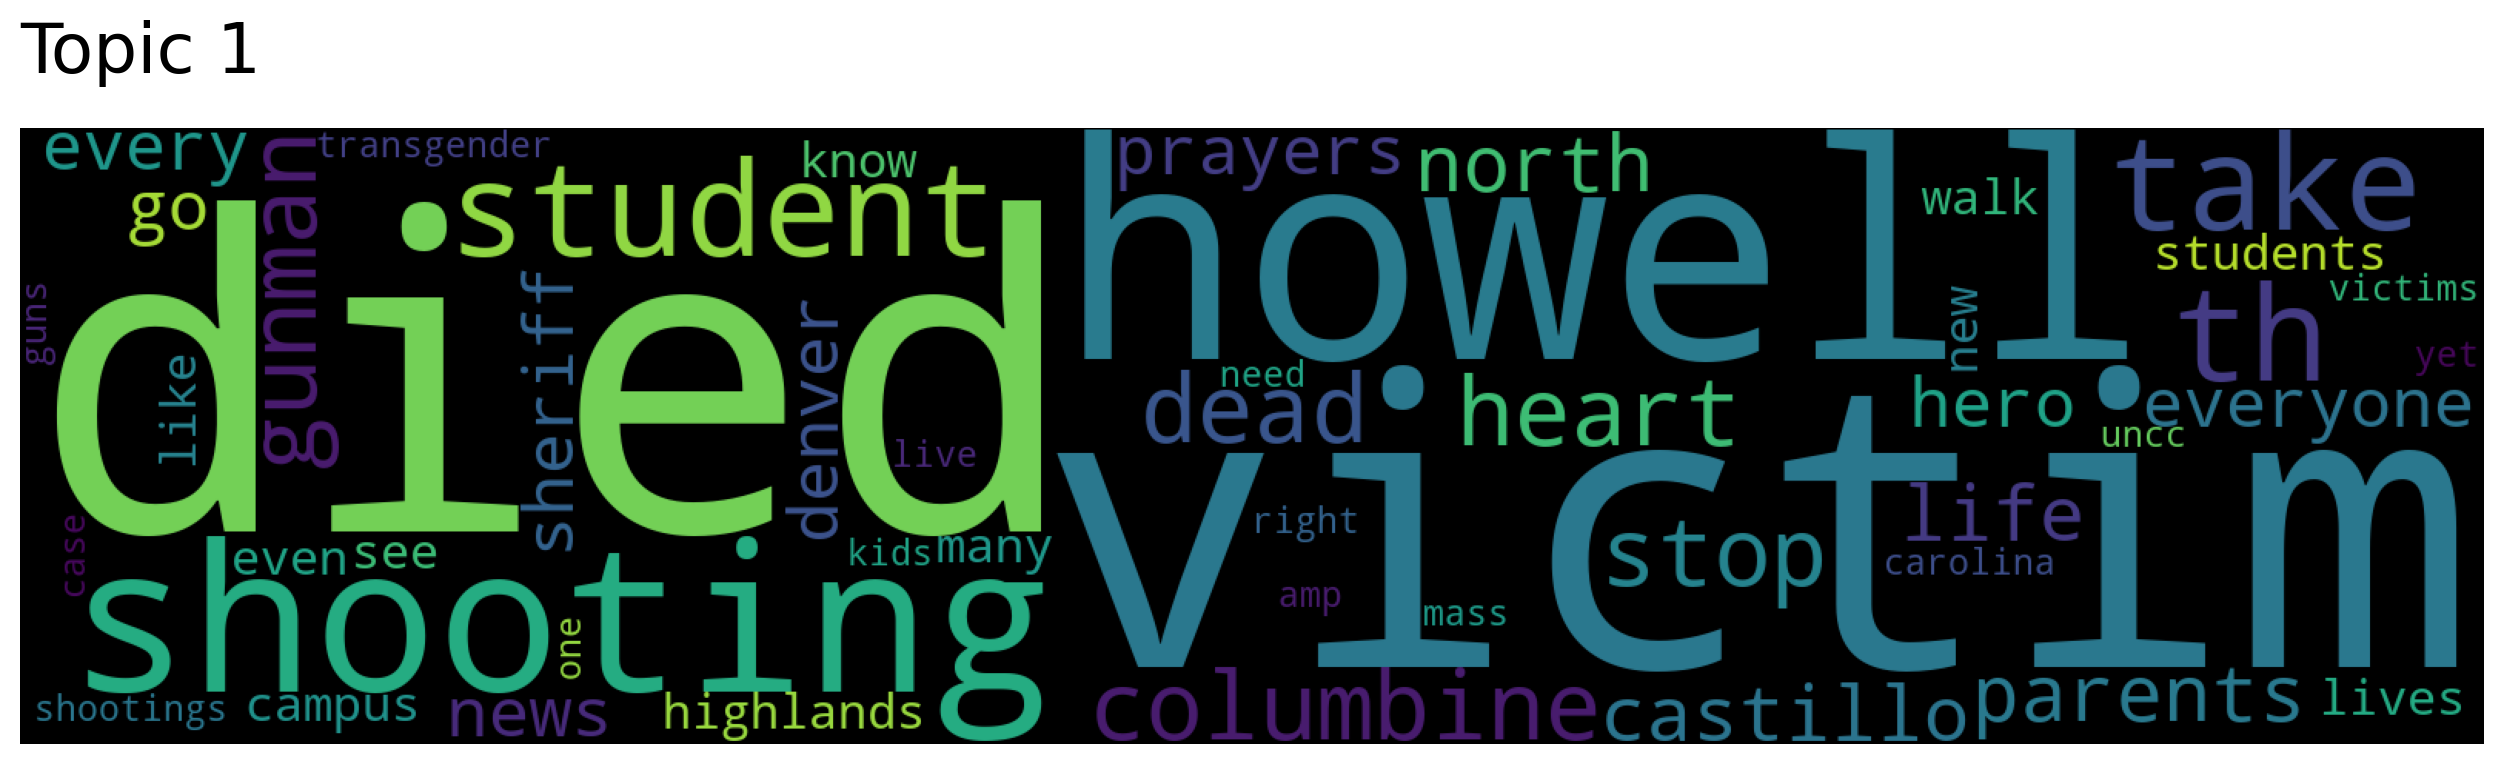

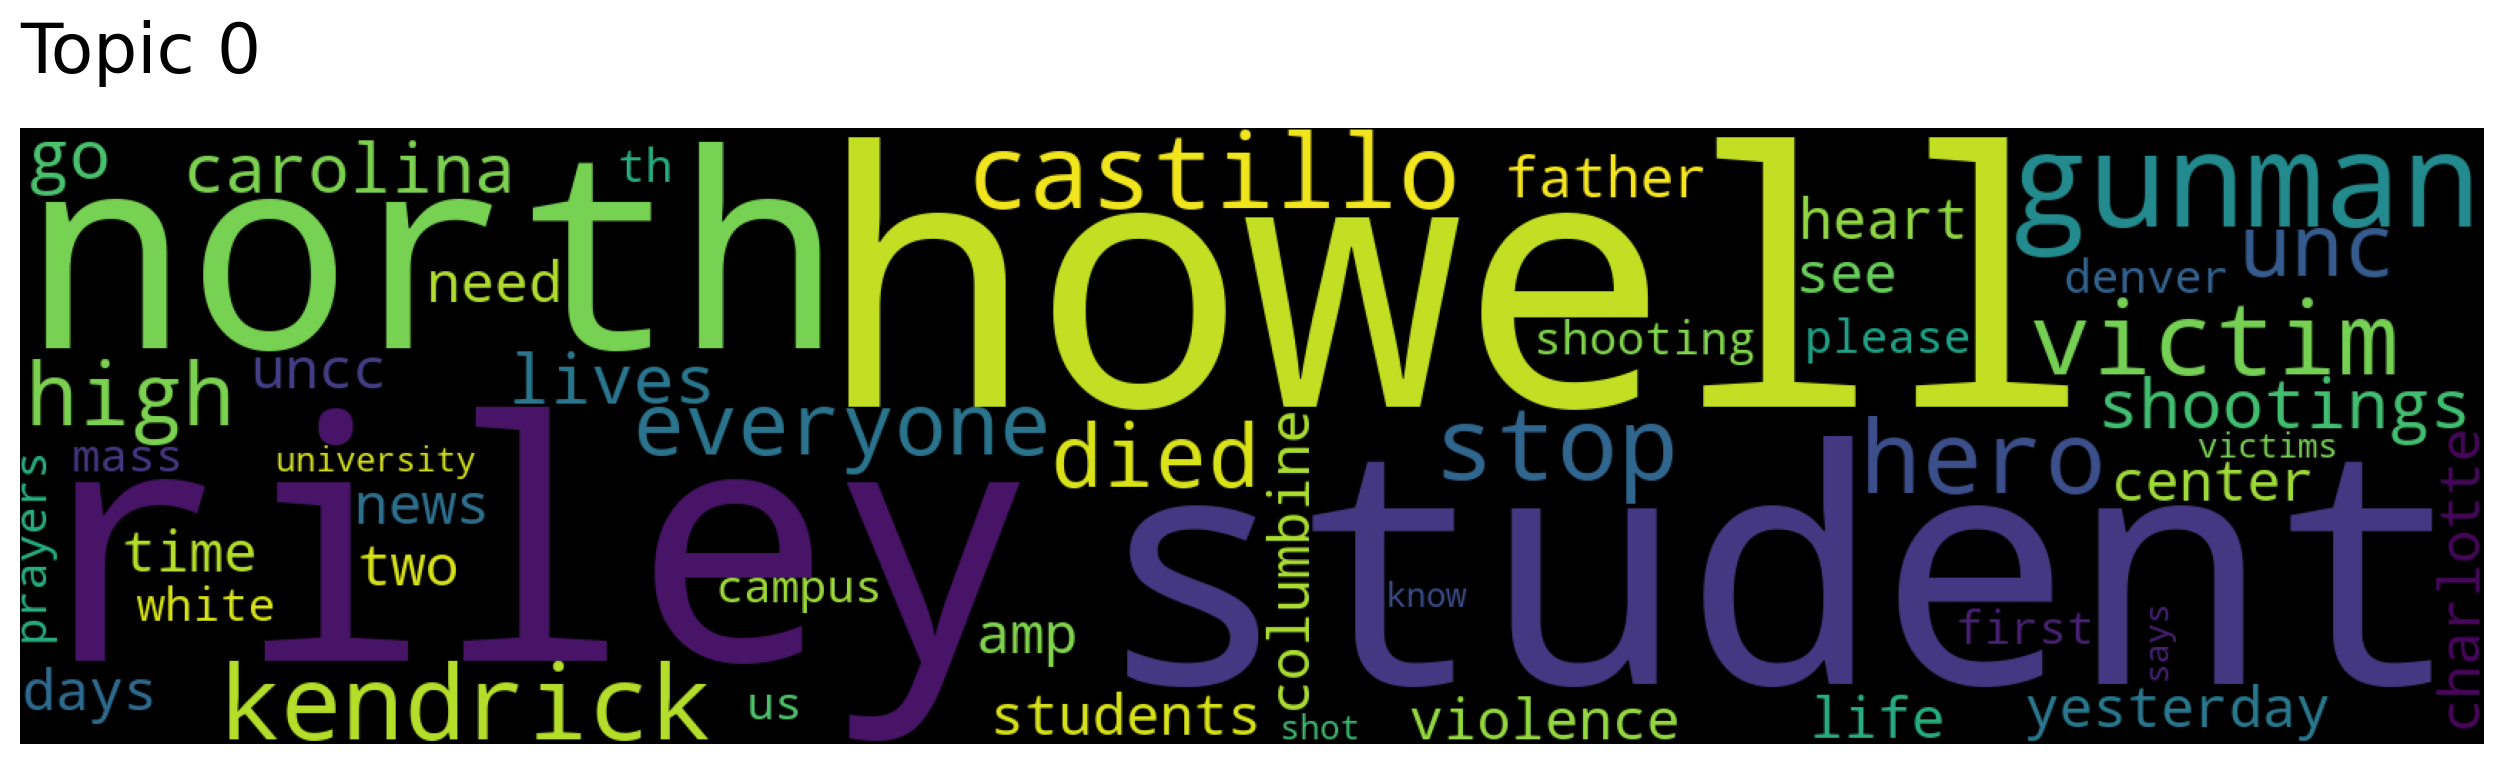

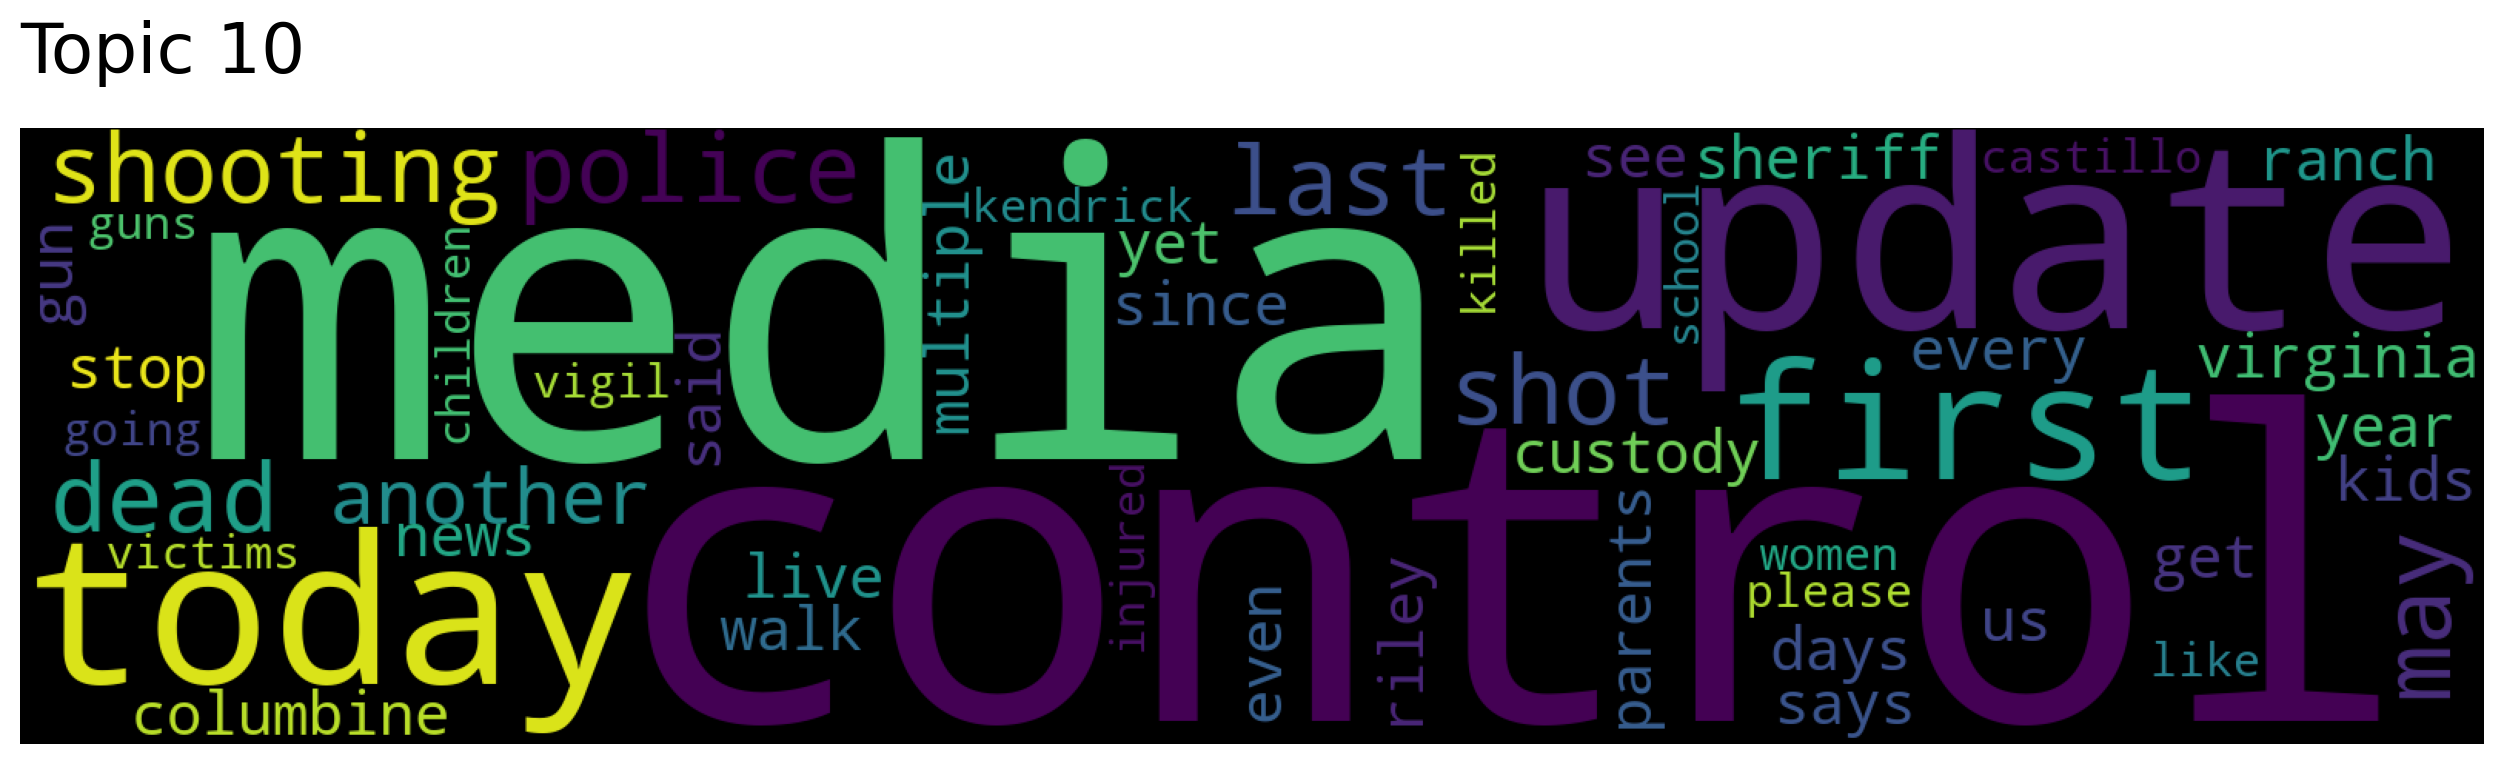

In [29]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["stem" , "shooting"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [30]:
import pickle
filename = 'Top2Vec.sav'
pickle.dump(model, open(filename, 'wb'))